In [217]:
#import JPype1
from konlpy.tag import Hannanum
from konlpy.utils import pprint
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import datetime
import tensorflow as tf
from datetime import datetime, timedelta
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import pandas as pd
from sklearn.model_selection import train_test_split
import requests
import urllib.request
import urllib.parse
from urllib.request import urlopen
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
import os
os.chdir('F:/news/newss')
# ## 주가 읽기

In [218]:
def read_file():
    stock = pd.read_csv("sk하이닉스.csv")
    stock['date'] = pd.to_datetime(stock['date'], format ='%Y-%m-%d')
    for i in range(len(stock)):
        stock['per'][i]=(float(stock['per'][i].replace("%",""))/100)

    # # 뉴스 url읽기
    url = pd.read_csv("crawling_news2.txt", header = None, names = ["date","href"])
    url['per']= "A"
    return url, stock

In [219]:
url, stock = read_file()
print("read_file")

read_file


<ipython-input-218-19941ed10af7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock['per'][i]=(float(stock['per'][i].replace("%",""))/100)


In [223]:
def lte_year(data,year):
    url_lte_2019=[]
    for i in range(len(data)):
        if int(url['date'].iloc[i][:2]) > int(str(pd.Timestamp.today())[2:4]):
            year = int(url['date'].iloc[i][:2]) + 1900
        else :
            year = int(url['date'].iloc[i][:2]) + 2000
        url['date'].iloc[i] = pd.Timestamp(year , int(url['date'].iloc[i][3:5]) , int(url['date'].iloc[i][6:8]))
        if pd.Timestamp(url['date'].iloc[i]) >= pd.Timestamp(year,1,1):
            url_lte_2019.append(i)
    data = data.iloc[url_lte_2019]
    return data

In [224]:
int(url['date'].iloc[1][0:2])

21

In [225]:
url = lte_year(url,2015)
# url = url.reset_index()

In [226]:
url.to_csv('url.csv')

In [227]:
#전처리
def Pretreatment(url,stock):
    for i in range(len(url)):
        while url['date'].iloc[i] not in list(stock['date']):
            url['date'].iloc[i]=url['date'].iloc[i]+timedelta(days=1)
        for j in range(len(stock)):
            if url['date'].iloc[i] == stock['date'].iloc[j]:
                url['per'].iloc[i] = stock['per'].iloc[j-1] #다음날 주가

    te4 = pd.DataFrame(url)
    te4 =te4.drop_duplicates(["date"])
    q1 = te4["per"].quantile(.25)
    q3 = te4["per"].quantile(.75)
    for i in range(len(url)):
        if url['per'].iloc[i] > q3:
            url['per'].iloc[i] = 0
        elif url['per'].iloc[i] <= q3 and url['per'].iloc[i]>0:
            url['per'].iloc[i] = 1
        elif url['per'].iloc[i] <= 0 and url['per'].iloc[i]>q1:
            url['per'].iloc[i] = 2
        else:
            url['per'].iloc[i] = 3
    return url

    # ### 퍼센트 원 핫 인코딩

    # ##### 원핫 인코딩 y값 제거해야 한다 함

    # from tensorflow.keras.utils import to_categorical
    # #float(te4["per"][1])
    # url['per'] = list(to_categorical(url['per']))
    #

In [228]:
url = Pretreatment(url,stock)
print("Pretreatment")

Pretreatment


In [229]:
url

,date,href,per
0,2021-05-17 00:00:00,https://www.mbn.co.kr/pages/news/newsView.php...,0
1,2021-05-17 00:00:00,https://www.mbn.co.kr/pages/news/newsView.php...,0
2,2021-05-17 00:00:00,https://www.mbn.co.kr/pages/news/newsView.php...,0
3,2021-05-16 00:00:00,https://www.mbn.co.kr/pages/news/newsView.php...,3
4,2021-05-16 00:00:00,https://www.mbn.co.kr/pages/news/newsView.php...,3
5,2021-05-16 00:00:00,https://www.mbn.co.kr/pages/news/newsView.php...,3
6,2021-05-14 00:00:00,https://www.mbn.co.kr/pages/news/newsView.php...,2
7,2021-04-06 00:00:00,https://www.mbn.co.kr/pages/news/newsView.php...,1
8,2021-04-06 00:00:00,https://www.mbn.co.kr/pages/news/newsView.php...,1
9,2021-04-05 00:00:00,https://www.mbn.co.kr/pages/news/newsView.php...,2


In [230]:
url.to_csv('url_Pretreatment.csv')

In [231]:
#test와 train데이터 분리

# # 전처리 및 토큰화
def morpheme(data):
    soup_content=[]
    j=0
    for i in range(len(data)):
        webpage = requests.get(data['href'].iloc[i])
        soup = BeautifulSoup(webpage.content, "html.parser")
        soup = soup.select_one('#newsViewArea').get_text()
        soup = re.sub('[^ㄱ-ㅎㅏ-ㅣ가-힣A-Za-z ]', '', soup)
        soup_content.append(soup)
    return soup_content

In [232]:
url_content = url
url_content['content']=morpheme(url)
print("morpheme")


morpheme


In [233]:
url_content

,date,href,per,content
0,2021-05-17 00:00:00,https://www.mbn.co.kr/pages/news/newsView.php...,0,삼성전자의 국내 직원 수가 만명을 돌파하며 역대 최대치를 기록했다일 삼성전자는 분기...
1,2021-05-17 00:00:00,https://www.mbn.co.kr/pages/news/newsView.php...,0,SK하이닉스가 옛 매그나칩반도체의 파운드리사업부법인명 키파운드리 인수를 추진한다 일...
2,2021-05-17 00:00:00,https://www.mbn.co.kr/pages/news/newsView.php...,0,지난해 국내 대 기업의 매출 외형은 전년대비 조원정도 감소했고 같은 기간 매출 조...
3,2021-05-16 00:00:00,https://www.mbn.co.kr/pages/news/newsView.php...,3,올해 개인투자자가 유가증권시장에서 조원 넘게 순매수한 것으로 집계됐다 이는 지난해...
4,2021-05-16 00:00:00,https://www.mbn.co.kr/pages/news/newsView.php...,3,일 서울 삼성동 코엑스에서 열린 서울머니쇼에서 박종대 하나금융투자 수석연구위원이...
5,2021-05-16 00:00:00,https://www.mbn.co.kr/pages/news/newsView.php...,3,주말용 콘텐츠 머니콕은 매주 엄선한 투자 전문가와의 심층 인터뷰를 통해 믿을 만한 ...
6,2021-05-14 00:00:00,https://www.mbn.co.kr/pages/news/newsView.php...,2,삼성바이오로직스 주가가 일 사상 최고가를 기록하며 시가총액에서도 위에 올라섰다 미...
7,2021-04-06 00:00:00,https://www.mbn.co.kr/pages/news/newsView.php...,1,미국 대표 메모리반도체 업체 마이크론이 분기월 결산법인으로 년 월년 월에 해당 호실...
8,2021-04-06 00:00:00,https://www.mbn.co.kr/pages/news/newsView.php...,1,코스피가 오늘일 상승세로 출발했습니다이날 오전 시 분 현재 코스피는 전날보다 포인트...
9,2021-04-05 00:00:00,https://www.mbn.co.kr/pages/news/newsView.php...,2,공매도 재개 시점이 한 달 앞으로 다가오면서 동학개미들이 좌불안석이다 오는 월 일...


In [234]:
url_content.to_csv('url_content_morpheme.csv')

In [235]:
def Delete_cospi(data):
    delete_cospi=[]
    for i in range(len(data)):
        if re.search("코스피", data['content'].iloc[i]) != None:
            delete_cospi.append(i)
    return data.drop(delete_cospi)

In [236]:
url_content = Delete_cospi(url_content)

In [237]:
url_content.to_csv('url_content_dropkospi.csv')

In [238]:
from sklearn.cluster import KMeans
def cluster_group(data):
    vocab_size = 1000  # 상위 500 단어만 사용
    tokenizer = Tokenizer(num_words = vocab_size + 1)
    tokenizer.fit_on_texts(data['content'])
    clustering = tokenizer.texts_to_sequences(data['content'])
    clustering = pad_sequences(clustering, maxlen = 500, padding='post')
    # 군집화 할 그룹의 갯수 정의
    n_clusters = 4
    kmeans = KMeans(n_clusters=n_clusters).fit(clustering)

    # trained labels and cluster centers
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_

    #labels에 merge
    return labels

In [239]:
url_content['labels'] = cluster_group(url_content)

In [240]:
# row 생략 없이 출력
pd.set_option('display.max_rows', None)
# col 생략 없이 출력
pd.set_option('display.max_columns', None)
url_content

,date,href,per,content,labels
0,2021-05-17 00:00:00,https://www.mbn.co.kr/pages/news/newsView.php...,0,삼성전자의 국내 직원 수가 만명을 돌파하며 역대 최대치를 기록했다일 삼성전자는 분기...,3
1,2021-05-17 00:00:00,https://www.mbn.co.kr/pages/news/newsView.php...,0,SK하이닉스가 옛 매그나칩반도체의 파운드리사업부법인명 키파운드리 인수를 추진한다 일...,1
2,2021-05-17 00:00:00,https://www.mbn.co.kr/pages/news/newsView.php...,0,지난해 국내 대 기업의 매출 외형은 전년대비 조원정도 감소했고 같은 기간 매출 조...,0
4,2021-05-16 00:00:00,https://www.mbn.co.kr/pages/news/newsView.php...,3,일 서울 삼성동 코엑스에서 열린 서울머니쇼에서 박종대 하나금융투자 수석연구위원이...,3
5,2021-05-16 00:00:00,https://www.mbn.co.kr/pages/news/newsView.php...,3,주말용 콘텐츠 머니콕은 매주 엄선한 투자 전문가와의 심층 인터뷰를 통해 믿을 만한 ...,0
6,2021-05-14 00:00:00,https://www.mbn.co.kr/pages/news/newsView.php...,2,삼성바이오로직스 주가가 일 사상 최고가를 기록하며 시가총액에서도 위에 올라섰다 미...,3
7,2021-04-06 00:00:00,https://www.mbn.co.kr/pages/news/newsView.php...,1,미국 대표 메모리반도체 업체 마이크론이 분기월 결산법인으로 년 월년 월에 해당 호실...,1
10,2021-04-05 00:00:00,https://www.mbn.co.kr/pages/news/newsView.php...,2,미국과 중국의 세계 반도체 공급망 패권 경쟁이 가열되면서 국내 반도체 산업도 긴장...,3
12,2021-04-04 00:00:00,https://www.mbn.co.kr/pages/news/newsView.php...,0,사진 출처 게티이미지뱅크 신종 코로나바이러스 감염증코로나발 연봉 파티를 즐기는 ...,3
13,2021-04-01 00:00:00,https://www.mbn.co.kr/pages/news/newsView.php...,1,애플 협력업체에서 청정에너지를 생성하고 있는 모습 협력업체들은 전세계 지역사회에 ...,1


In [241]:
all_data=url_content.reset_index()

In [242]:
#합치면 라벨을 못살림
# def merge_group(data):
#     for i in range(len(data)):
#         if i == 0 :
#             news_group_date = data['date'][i]
#             news_group_content = soup
#             count = 1
#             news_group = pd.DataFrame([news_group_date,news_group_content,data['per'][i],count],['date','content','per','count']).transpose()
#             continue
#         if news_group['date'][j] == data['date'][i]:
#             news_group['content'][j] = news_group['content'][j] + soup
#             count + 1
#             news_group['count'][j] = count
#         else :
#             j = j + 1
#             count = 1
#             a = {'date':data['date'][i],'content':soup,'per':data['per'][i],'count':count}
#             news_group = news_group.append(a,ignore_index=True)
# return news_group

In [243]:
all_data

,index,date,href,per,content,labels
0,0,2021-05-17 00:00:00,https://www.mbn.co.kr/pages/news/newsView.php...,0,삼성전자의 국내 직원 수가 만명을 돌파하며 역대 최대치를 기록했다일 삼성전자는 분기...,3
1,1,2021-05-17 00:00:00,https://www.mbn.co.kr/pages/news/newsView.php...,0,SK하이닉스가 옛 매그나칩반도체의 파운드리사업부법인명 키파운드리 인수를 추진한다 일...,1
2,2,2021-05-17 00:00:00,https://www.mbn.co.kr/pages/news/newsView.php...,0,지난해 국내 대 기업의 매출 외형은 전년대비 조원정도 감소했고 같은 기간 매출 조...,0
3,4,2021-05-16 00:00:00,https://www.mbn.co.kr/pages/news/newsView.php...,3,일 서울 삼성동 코엑스에서 열린 서울머니쇼에서 박종대 하나금융투자 수석연구위원이...,3
4,5,2021-05-16 00:00:00,https://www.mbn.co.kr/pages/news/newsView.php...,3,주말용 콘텐츠 머니콕은 매주 엄선한 투자 전문가와의 심층 인터뷰를 통해 믿을 만한 ...,0
5,6,2021-05-14 00:00:00,https://www.mbn.co.kr/pages/news/newsView.php...,2,삼성바이오로직스 주가가 일 사상 최고가를 기록하며 시가총액에서도 위에 올라섰다 미...,3
6,7,2021-04-06 00:00:00,https://www.mbn.co.kr/pages/news/newsView.php...,1,미국 대표 메모리반도체 업체 마이크론이 분기월 결산법인으로 년 월년 월에 해당 호실...,1
7,10,2021-04-05 00:00:00,https://www.mbn.co.kr/pages/news/newsView.php...,2,미국과 중국의 세계 반도체 공급망 패권 경쟁이 가열되면서 국내 반도체 산업도 긴장...,3
8,12,2021-04-04 00:00:00,https://www.mbn.co.kr/pages/news/newsView.php...,0,사진 출처 게티이미지뱅크 신종 코로나바이러스 감염증코로나발 연봉 파티를 즐기는 ...,3
9,13,2021-04-01 00:00:00,https://www.mbn.co.kr/pages/news/newsView.php...,1,애플 협력업체에서 청정에너지를 생성하고 있는 모습 협력업체들은 전세계 지역사회에 ...,1


In [244]:
def text_except_all(data):
    tokken = []
    tok=[]
    hannanum=Hannanum()
    for i in range(len(data)):
        tokken.append(hannanum.pos(data['content'][i]))

    # ### 토큰 중 가장 긴 토큰을 기준으로 반복 및 형태소 중 명사 동사 선택

    lenA = []
    for i in range(len(tokken)):
        lenA.append(len(tokken[i]))
    max(lenA)

    
    Stopword = pd.read_csv("한국어불용어100.txt", header=None, names=['text','x','num'],delimiter = '\t')
    for i in range(len(tokken)):
        all_tokken=[]
        for j in range(lenA[i]):
            if tokken[i][j][1] == 'N' and tokken[i][j][0] not in Stopword['text'].values:
                all_tokken.append(tokken[i][j][0])
        tok.append(all_tokken)
    return tok

In [245]:
all_data['content'] = text_except_all(all_data)
# print("text_except")

In [246]:
all_data

,index,date,href,per,content,labels
0,0,2021-05-17 00:00:00,https://www.mbn.co.kr/pages/news/newsView.php...,0,"[삼성전자, 국내, 직원, 만명, 돌파, 역대, 최대치, 기록했다, 삼성전자, 분기...",3
1,1,2021-05-17 00:00:00,https://www.mbn.co.kr/pages/news/newsView.php...,0,"[SK하이닉스, 매그나칩반도체, 파운드리사업부법인명, 키파운드리, 추진, 관련, 업...",1
2,2,2021-05-17 00:00:00,https://www.mbn.co.kr/pages/news/newsView.php...,0,"[지난해, 국내, 대, 기업, 매출, 외형, 전년대비, 조원정도, 감소, 기간, 매...",0
3,4,2021-05-16 00:00:00,https://www.mbn.co.kr/pages/news/newsView.php...,3,"[서울, 삼성동, 코엑스, 서울머니쇼, 박종대, 하나금융투, 수석연구위원, 유통생활...",3
4,5,2021-05-16 00:00:00,https://www.mbn.co.kr/pages/news/newsView.php...,3,"[주말용, 콘텐츠, 머니콕, 엄선, 투, 전문가, 심층, 인터뷰, 만한, 재테크, ...",0
5,6,2021-05-14 00:00:00,https://www.mbn.co.kr/pages/news/newsView.php...,2,"[삼성바이오로직스, 주가, 사상, 최고가, 기록, 시가총액, 위, 미국, 모더나, ...",3
6,7,2021-04-06 00:00:00,https://www.mbn.co.kr/pages/news/newsView.php...,1,"[미국, 대표, 메모리반도체, 업체, 마이크론, 분기월, 결산법인, 월년, 해당, ...",1
7,10,2021-04-05 00:00:00,https://www.mbn.co.kr/pages/news/newsView.php...,2,"[미국, 중국, 세계, 반도체, 공급망, 패권, 경쟁, 가열, 국내, 반도체, 산업...",3
8,12,2021-04-04 00:00:00,https://www.mbn.co.kr/pages/news/newsView.php...,0,"[출처, 게티이미지뱅크, 신종, 코로나바이러스, 감염증코로나발, 연봉, 파티, 회사...",3
9,13,2021-04-01 00:00:00,https://www.mbn.co.kr/pages/news/newsView.php...,1,"[애플, 협력업체, 청정에너지, 생성, 모습, 협력업체들, 전세계, 지역사회, 기가...",1


In [247]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_data['content'])

vocab_size = 1000  # 상위 500 단어만 사용
tokenizer = Tokenizer(num_words = vocab_size + 1)
tokenizer.fit_on_texts(all_data['content'])

print(tokenizer.word_index) #인덱스가 어떻게 부여됬는지(입력된 단어 순서)
print(tokenizer.word_counts) #상위 몇개 단어를 했을 때 어떻게 부여됬는지(입력된 단어 순서)

def text_size(num):
    threshold = num
    total_cnt = len(tokenizer.word_index) # 단어의 수
    rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
    total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
    rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

    # 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
    for key, value in tokenizer.word_counts.items():
        total_freq = total_freq + value

        # 단어의 등장 빈도수가 threshold보다 작으면
        if(value < threshold):
            rare_cnt = rare_cnt + 1
            rare_freq = rare_freq + value

    print('단어 집합(vocabulary)의 크기 :',total_cnt)
    print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
    print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
    print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

    #단어수가 2개인 단어의 빈도가 6.1%라 유의미한 영향을 줄 수 있어 제외하지 않는다

    # 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
    # 0번 패딩 토큰을 고려하여 + 1
    vocab_size = total_cnt - rare_cnt + 1
    print('단어 집합의 크기 :',vocab_size)


    # ## 앞의 형태소분석을 붙여씀
    # ### 불필요하게 주가를 넣는 부분이 있고 href에서 본문을 따오는 부분 함수화 고려

text_size(2)

{'sk하이닉스': 1, '반도체': 2, '분기': 3, '억원': 4, '실적': 5, '삼성전자': 6, '기': 7, '기업': 8, '금지': 9, '올해': 10, '위': 11, '무단전재': 12, '재배포': 13, '시장': 14, '대비': 15, '영업이익': 16, '지난해': 17, '주가': 18, '조억원': 19, '매출': 20, '만원': 21, '기록': 22, '전망': 23, '국내': 24, '증가': 25, '수요': 26, '램': 27, '하락': 28, '중국': 29, '예상': 30, '연구원': 31, '규모': 32, '그룹': 33, '상승': 34, '미국': 35, '가격': 36, '종목': 37, '사업': 38, '기준': 39, '감소': 40, '메모리': 41, '이후': 42, '분석': 43, '글로벌': 44, '업계': 45, '수준': 46, '작년': 47, '조': 48, '이상': 49, '공급': 50, '전년': 51, '경기': 52, '회장': 53, '대': 54, '일본': 55, '주요': 56, '회사': 57, '조원': 58, '투자': 59, '확대': 60, '생산': 61, '부진': 62, '업체': 63, '매각': 64, '곳': 65, '공장': 66, '하반기': 67, '지속': 68, '약': 69, '시': 70, '거래': 71, '이날': 72, '제품': 73, '텔레콤': 74, '협력사': 75, '한국': 76, '내년': 77, '가능성': 78, '지원': 79, '를': 80, '영향': 81, '상황': 82, '투': 83, '동기': 84, '관계자': 85, '진행': 86, '성장': 87, '기술': 88, '부문': 89, '억': 90, '가운데': 91, '발표': 92, '낸드': 93, '시가총액': 94, '보유': 95, '지분': 96, '평가': 97, '정부': 98, '도시바': 99, '최대

In [248]:
def train_test(data):
    train, test = train_test_split(data, test_size= 0.2, random_state=1234)

    #인덱스 초기화
    train = train.reset_index()
    test = test.reset_index()
    return train, test

train, test = train_test(all_data)
print("train_test")

train_test


In [249]:
print(len(train))
print(len(test))

230
58


In [250]:
all_data['content']

0      [삼성전자, 국내, 직원, 만명, 돌파, 역대, 최대치, 기록했다, 삼성전자, 분기...
1      [SK하이닉스, 매그나칩반도체, 파운드리사업부법인명, 키파운드리, 추진, 관련, 업...
2      [지난해, 국내, 대, 기업, 매출, 외형, 전년대비, 조원정도, 감소, 기간, 매...
3      [서울, 삼성동, 코엑스, 서울머니쇼, 박종대, 하나금융투, 수석연구위원, 유통생활...
4      [주말용, 콘텐츠, 머니콕, 엄선, 투, 전문가, 심층, 인터뷰, 만한, 재테크, ...
5      [삼성바이오로직스, 주가, 사상, 최고가, 기록, 시가총액, 위, 미국, 모더나, ...
6      [미국, 대표, 메모리반도체, 업체, 마이크론, 분기월, 결산법인, 월년, 해당, ...
7      [미국, 중국, 세계, 반도체, 공급망, 패권, 경쟁, 가열, 국내, 반도체, 산업...
8      [출처, 게티이미지뱅크, 신종, 코로나바이러스, 감염증코로나발, 연봉, 파티, 회사...
9      [애플, 협력업체, 청정에너지, 생성, 모습, 협력업체들, 전세계, 지역사회, 기가...
10     [카카오뱅크, 주도하, 카카오, 본사, 출처, 카카오, SK하이닉스SK텔레콤현대차네...
11     [마이크론, 테크놀로지, 시장, 예상치, 분기, 실적, 달성, SK하이닉스, 삼성전...
12     [내로남불, 부동산, 논란, 경기도의회, 의원, 경기, 토지, 보유, 확인, 직원,...
13     [삼성전자, SK하이닉스, 슈퍼사이클, 기대감, 강세다, 오전, 시, 분, 삼성전자...
14     [SK하이닉스, 개장, 장중, 대, 주당, 만원, 선, 올라섰다, 오전, 시분, S...
15     [국민연금, 매도공세, 대해부, 연기금, 국내, 증시, 역사적, 최장기간, 순매, ...
16     [램, 메모리, 반도체, 업황, 판단, 기준, D램익스체, 인덱스DXI, 사상, 최...
17     [수출, 넉, 달, 연속, 증가세, 하루, 

In [251]:
len(url['content'])

767

뉴스의 최대 길이 : 633
뉴스의 평균 길이 : 44.69491525423729


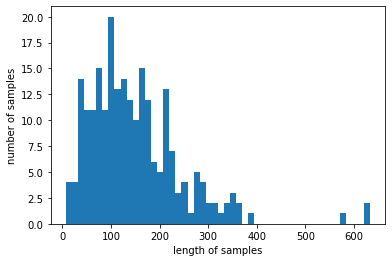

In [252]:
# ## 패딩

def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))


print('뉴스의 최대 길이 :',max(len(l) for l in train['content']))
print('뉴스의 평균 길이 :',sum(map(len, train['content']))/len(url))
plt.hist([len(s) for s in train['content']], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [253]:
max_len = 400
below_threshold_len(max_len, train['content'])

전체 샘플 중 길이가 400 이하인 샘플의 비율: 98.69565217391305


In [254]:
# train_data = morpheme(train)
# test_data = morpheme(test)

# train_data['content'] = text_except(train_data['content'])
# test_data['content'] = text_except(test_data['content'])

# X_train = train['content']
# X_test = test['content']

X_train = tokenizer.texts_to_sequences(train['content'])
X_test = tokenizer.texts_to_sequences(test['content'])
X_train = pad_sequences(X_train, maxlen = max_len, padding='post')
X_test = pad_sequences(X_test, maxlen = max_len, padding='post')



X_train2 = pd.DataFrame(X_train)
la = pd.DataFrame(train['labels'].astype(np.float64))
X_train2=X_train2.astype('float64')
X_train2 = pd.concat([X_train2,la],ignore_index=True,axis=1)

X_test2 = pd.DataFrame(X_test)
X_test2=X_test2.astype('float64')
la2 = pd.DataFrame(test['labels'].astype(np.float64))
X_test2 = pd.concat([X_test2,la2],ignore_index=True,axis=1)


y_train = train['per'].astype(np.float64)
y_train = pd.DataFrame(y_train)
y_test = test['per'].astype(np.float64)
y_test = pd.DataFrame(y_test)


#(size, timestep, feature)
X_train2 = np.array(X_train2).reshape(X_train2.shape[0], X_train2.shape[1],1)
y_train = np.array(y_train).reshape(y_train.shape[0], y_train.shape[1], 1)
X_test2 = np.array(X_test2).reshape(X_test2.shape[0], X_test2.shape[1], 1)
y_test = np.array(y_test).reshape(y_test.shape[0], y_test.shape[1], 1)

drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
# 빈 샘플들을 제거
# X_train = np.delete(X_train, drop_train, axis=0)
# y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

230
230


In [255]:
len(X_test)

58

In [256]:
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [257]:
model = Sequential()
model.add(Bidirectional(LSTM(128, input_shape = (len(X_train2),1))))
model.add(Dropout(0.2, input_shape=(len(X_train2),1)))
initializer = tf.keras.initializers.HeNormal() #가중치 초기화
model.add(Dense(90, activation='relu',kernel_initializer=initializer))
model.add(Dense(90, activation='relu'))
model.add(Dense(4, activation='softmax'))

In [201]:
model = Sequential()
#model.add(Embedding(vocab_size, 100)) #모델에 입력크기를 고정된 크기고 제한
#model.add(Dense(2, activation='softmax'))
model.add(LSTM(128, input_shape = (len(X_train),1)))
#,return_sequences=True, input_shape = (300,1) 입력형식, stateful=True 상태유지
# model.add(Dropout(0.2, input_shape=(270,1)))
initializer = tf.keras.initializers.HeNormal() #가중치 초기화
model.add(Dense(90, activation='relu',kernel_initializer=initializer))
model.add(Dense(90, activation='relu'))
model.add(Dense(4, activation='softmax'))

In [258]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc','sparse_categorical_accuracy'])
history = model.fit(X_train2, y_train, epochs=100, callbacks=[es, mc], batch_size=60, validation_split=0.2)
#validation_split 전체데이터(train)중 얼마를 검토(test)할 것이냐
#batch_size 계산 후 가중치를 넘길 계산 단위

Epoch 1/100
19/19 [==============================] - 10s 322ms/step - loss: 1.3781 - acc: 0.3564 - sparse_categorical_accuracy: 0.3564 - val_loss: 1.3723 - val_acc: 0.3913 - val_sparse_categorical_accuracy: 0.3913

Epoch 00001: val_acc improved from -inf to 0.39130, saving model to best_model.h5
Epoch 2/100
19/19 [==============================] - 5s 267ms/step - loss: 1.3202 - acc: 0.3730 - sparse_categorical_accuracy: 0.3730 - val_loss: 1.3215 - val_acc: 0.3913 - val_sparse_categorical_accuracy: 0.3913

Epoch 00002: val_acc did not improve from 0.39130
Epoch 3/100
19/19 [==============================] - 5s 268ms/step - loss: 1.3139 - acc: 0.4398 - sparse_categorical_accuracy: 0.4398 - val_loss: 1.3199 - val_acc: 0.4565 - val_sparse_categorical_accuracy: 0.4565

Epoch 00003: val_acc improved from 0.39130 to 0.45652, saving model to best_model.h5
Epoch 4/100
19/19 [==============================] - 5s 272ms/step - loss: 1.2926 - acc: 0.4074 - sparse_categorical_accuracy: 0.4074 - val_

2/2 [==============================] - 1s 120ms/step - loss: 1.3582 - acc: 0.3966 - sparse_categorical_accuracy: 0.3966

 테스트 정확도: 0.3966


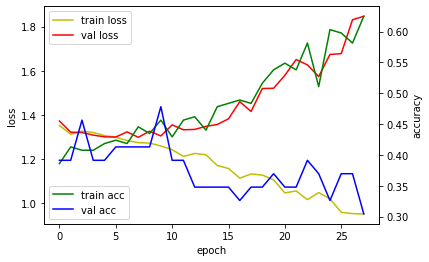

In [259]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test2, y_test)[1]))

# 학습 결과 그래프 그리기

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

acc_ax.plot(history.history['sparse_categorical_accuracy'], 'g', label='train acc')
acc_ax.plot(history.history['val_sparse_categorical_accuracy'], 'b', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')
plt.show()

# # 끝